# Dynamics 365 Business Central Troubleshooting Guide (TSG) - Connectors (PowerBI, PowerApps, LogicApps, or Flow)

This notebook contains Kusto queries that can help getting to the root cause of an issue with usage of any of the connectors from PowerBI, PowerApps, LogicApps, or Flow. 

Each section in the notebook contains links to relevant documentation from the performance tuning guide [aka.ms/bcperformance](aka.ms/bcperformance),   telemetry documentation in [aka.ms/bctelemetry](aka.ms/bctelemetry), as well as Kusto queries that help dive into a specific area.

NB! The signal used in this notebook is only available in versions 16.3 (or newer) of Business Central, so check the version of your environment if some sections do not return any data.

## 1\. Get setup: Load up Python libraries and connect to Application Insights

First you need to set the notebook Kernel to Python3, load the KQLmagic module (did you install it? Install instructions: https://github.com/microsoft/BCTech/tree/master/samples/AppInsights/TroubleShootingGuides) and connect to Application Insights


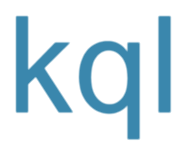

In [4]:
# load the KQLmagic module
%reload_ext Kqlmagic

In [5]:
# Connect to the Application Insights API
%kql appinsights://appid='<add app id from the Application Insights portal>';appkey='<add API key from the Application Insights portal>'

## 2\. Define filters

This workbook is designed for troubleshooting a single environment. Please provide values for aadTenantId and environmentName (or use a config file).

In [6]:
# Add values for AAD tenant id, environment name, and date range.
# It is possible to leave the value for AAD tenant id or environment name blank (if you want to analyze across all values of the parameter)

# You can either use configuration file (INI file format) or set filters directly. 

# If you specify a config file, then variables set here takes precedence over manually set filter variables
# config file name and directory (full path)
configFile = "c:\\tmp\\notebook.ini"


# Add AAD tenant id and environment name here
aadTenantId = ""
environmentName = ""

# date filters for the analysis
# use YYYY-MM-DD format for the dates (ISO 8601)
startDate = "2021-11-01"
endDate = "2022-01-01"



# Do not edit this code section
import configparser
config = configparser.ConfigParser()

config.read(configFile)

if bool(config.defaults()):
    if config.has_option('DEFAULT', 'aadTenantId'):
        aadTenantId = config['DEFAULT']['aadTenantId']
    if config.has_option('DEFAULT', 'environmentName'):
        environmentName = config['DEFAULT']['environmentName']
    if config.has_option('DEFAULT', 'extensionId'):
        extensionId = config['DEFAULT']['extensionId']
    if config.has_option('DEFAULT', 'startDate'):    
        startDate = config['DEFAULT']['startDate']
    if config.has_option('DEFAULT', 'endDate'):
        endDate = config['DEFAULT']['endDate']

print("Using these parameters for the analysis:")
print("----------------------------------------")
print("aadTenantId         " + aadTenantId)
print("environmentName     " + environmentName)
print("startDate           " + startDate)
print("endDate             " + endDate)

Using these parameters for the analysis:
----------------------------------------
aadTenantId         
environmentName     
startDate           2021-11-01
endDate             2022-01-01


# Analyze connector usage
Now you can run Kusto queries to look for possible root causes for issues about web services.

Either click **Run All** above to run all sections, or scroll down to the type of analysis you want to do and manually run queries

## Connector web service requests overview
All connectors use the OData v4 protocol to connect to Business Central. 

Web service telemetry docs: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace

KQL samples: https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/MicrosoftConnectorUsage.kql

In [7]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)    
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
    and customDimensions.category == 'ODataV4'
// httpHeaders and httpStatusCode only available from 16.3
| extend httpHeadersTmp =  tostring( customDimensions.httpHeaders)
| extend httpHeadersJSON = parse_json(httpHeadersTmp)
| extend msUserAgent = tostring( httpHeadersJSON.['ms-dyn-useragent'] )
| where msUserAgent has 'AzureConnector' or msUserAgent has 'PowerBIConnector' or msUserAgent has 'BusinessCentralLinkUnfurlingTeamsBot'
| extend httpStatusCode = customDimensions.httpStatusCode
, connector = case( 
// ms-dyn-useragent=AzureConnector/1.0 Flow/1.0 DynamicsSmbSaas/1.0.0.0
msUserAgent matches regex "AzureConnector/(.)+Flow", 'Flow'
// ["PowerBIConnector/1.0 PowerBI/1.0 Dynamics365BusinessCentral/1.1.5"]
, msUserAgent matches regex "PowerBIConnector/", 'Power BI'
// ms-dyn-useragent=AzureConnector/1.0 PowerApps/3.20092.39 DynamicsSmbSaas/1.0.0.0
, msUserAgent matches regex "AzureConnector/(.)+PowerApps", 'PowerApps'
// ms-dyn-useragent=AzureConnector/1.0 LogicApps/3.20092.39 DynamicsSmbSaas/1.0.0.0
, msUserAgent matches regex "AzureConnector/(.)+LogicApps", 'LogicApps'
// ms-dyn-useragent=BusinessCentralLinkUnfurlingTeamsBot
, msUserAgent has "BusinessCentralLinkUnfurlingTeamsBot", 'MSTeams'
, msUserAgent has 'AzureConnector', 'Unknown Azure connector'
, 'Unknown connector' 
)
| summarize request_count=count() by connector, bin(timestamp, 1d)
| render timechart title= 'Number of connector web service requests by category'

[]

In [8]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)    
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
    and customDimensions.category == 'ODataV4'
// httpHeaders and httpStatusCode only available from 16.3
| extend httpHeadersTmp =  tostring( customDimensions.httpHeaders)
| extend httpHeadersJSON = parse_json(httpHeadersTmp)
| extend msUserAgent = tostring( httpHeadersJSON.['ms-dyn-useragent'] )
| where msUserAgent has 'AzureConnector' or msUserAgent has 'PowerBIConnector' or msUserAgent has 'BusinessCentralLinkUnfurlingTeamsBot'
| extend httpStatusCode = customDimensions.httpStatusCode
, connector = case( 
// ms-dyn-useragent=AzureConnector/1.0 Flow/1.0 DynamicsSmbSaas/1.0.0.0
msUserAgent matches regex "AzureConnector/(.)+Flow", 'Flow'
// ["PowerBIConnector/1.0 PowerBI/1.0 Dynamics365BusinessCentral/1.1.5"]
, msUserAgent matches regex "PowerBIConnector/", 'Power BI'
// ms-dyn-useragent=AzureConnector/1.0 PowerApps/3.20092.39 DynamicsSmbSaas/1.0.0.0
, msUserAgent matches regex "AzureConnector/(.)+PowerApps", 'PowerApps'
// ms-dyn-useragent=AzureConnector/1.0 LogicApps/3.20092.39 DynamicsSmbSaas/1.0.0.0
, msUserAgent matches regex "AzureConnector/(.)+LogicApps", 'LogicApps'
// ms-dyn-useragent=BusinessCentralLinkUnfurlingTeamsBot
, msUserAgent has "BusinessCentralLinkUnfurlingTeamsBot", 'MSTeams'
, msUserAgent has 'AzureConnector', 'Unknown Azure connector'
, 'Unknown connector' 
)
, executionTimeInMS = toreal(totimespan(customDimensions.serverExecutionTime))/10000 //the datatype for executionTime is timespan 
| summarize count() by executionTime_ms = bin(executionTimeInMS, 100), connector
| extend log_count = log10( count_ )
| order by connector, executionTime_ms asc
| render columnchart with  (ycolumns = log_count, ytitle='log(count)', series = connector, title= 'Execution time (in milliseconds) of connector web service requests' ) 

[]

## Connector throttling
If web service requests exceed the operational limits in Business Central, then they will either be rejected (with a HTTP status code 426), or timeout (with a HTTP status code 408).

Operational Limits for Business Central Online: 
* https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/operational-limits-online#query-limits

Telemetry docs: 
* https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace

In [9]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
    and customDimensions.category == 'ODataV4'
// httpHeaders and httpStatusCode only available from 16.3
| extend httpHeadersTmp =  tostring( customDimensions.httpHeaders)
| extend httpHeadersJSON = parse_json(httpHeadersTmp)
| extend msUserAgent = tostring( httpHeadersJSON.['ms-dyn-useragent'] )
| where msUserAgent has 'AzureConnector' or msUserAgent has 'PowerBIConnector' or msUserAgent has 'BusinessCentralLinkUnfurlingTeamsBot'
| extend httpStatusCode = tostring( customDimensions.httpStatusCode )
, connector = case( 
// ms-dyn-useragent=AzureConnector/1.0 Flow/1.0 DynamicsSmbSaas/1.0.0.0
msUserAgent matches regex "AzureConnector/(.)+Flow", 'Flow'
// ["PowerBIConnector/1.0 PowerBI/1.0 Dynamics365BusinessCentral/1.1.5"]
, msUserAgent matches regex "PowerBIConnector/", 'Power BI'
// ms-dyn-useragent=AzureConnector/1.0 PowerApps/3.20092.39 DynamicsSmbSaas/1.0.0.0
, msUserAgent matches regex "AzureConnector/(.)+PowerApps", 'PowerApps'
// ms-dyn-useragent=AzureConnector/1.0 LogicApps/3.20092.39 DynamicsSmbSaas/1.0.0.0
, msUserAgent matches regex "AzureConnector/(.)+LogicApps", 'LogicApps'
// ms-dyn-useragent=BusinessCentralLinkUnfurlingTeamsBot
, msUserAgent has "BusinessCentralLinkUnfurlingTeamsBot", 'MSTeams'
, msUserAgent has 'AzureConnector', 'Unknown Azure connector'
, 'Unknown connector' 
)
| summarize count() by bin(timestamp, 1d), httpStatusCode, connector
| render timechart title= 'Number of connector requests by http status code'

[]

## Connector Web service requests (Access denied)
The user who made the request doesn't have proper permissions. For more information, see 
* https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/webservices/web-services-authentication
* https://docs.microsoft.com/en-us/dynamics365/business-central/ui-define-granular-permissions

Telemetry docs: 
* https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace

In [10]:
%%kql
//
// Top 10 endpoint requests with access denied
//
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
    and customDimensions.category == 'ODataV4'    
    and customDimensions.httpStatusCode == '401'
// httpHeaders and httpStatusCode only available from 16.3
| extend httpHeadersTmp =  tostring( customDimensions.httpHeaders)
| extend httpHeadersJSON = parse_json(httpHeadersTmp)
| extend msUserAgent = tostring( httpHeadersJSON.['ms-dyn-useragent'] )
| where msUserAgent has 'AzureConnector' or msUserAgent has 'PowerBIConnector' or msUserAgent has 'BusinessCentralLinkUnfurlingTeamsBot'
| extend httpStatusCode = customDimensions.httpStatusCode
, connector = case( 
// ms-dyn-useragent=AzureConnector/1.0 Flow/1.0 DynamicsSmbSaas/1.0.0.0
msUserAgent matches regex "AzureConnector/(.)+Flow", 'Flow'
// ["PowerBIConnector/1.0 PowerBI/1.0 Dynamics365BusinessCentral/1.1.5"]
, msUserAgent matches regex "PowerBIConnector/", 'Power BI'
// ms-dyn-useragent=AzureConnector/1.0 PowerApps/3.20092.39 DynamicsSmbSaas/1.0.0.0
, msUserAgent matches regex "AzureConnector/(.)+PowerApps", 'PowerApps'
// ms-dyn-useragent=AzureConnector/1.0 LogicApps/3.20092.39 DynamicsSmbSaas/1.0.0.0
, msUserAgent matches regex "AzureConnector/(.)+LogicApps", 'LogicApps'
// ms-dyn-useragent=BusinessCentralLinkUnfurlingTeamsBot
, msUserAgent has "BusinessCentralLinkUnfurlingTeamsBot", 'MSTeams'
, msUserAgent has 'AzureConnector', 'Unknown Azure connector'
, 'Unknown connector' 
)    
| summarize number_of_requests=count() by connector, endpoint = tostring( customDimensions.endpoint ), alObjectName = tostring( customDimensions.alObjectName ), alObjectId = tostring( customDimensions.alObjectId )
| limit 10

,connector,endpoint,alObjectName,alObjectId,number_of_requests


[]

## Connector web service requests (Not found)
The given endpoint was not valid

See
* https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/webservices/publish-web-service

Telemetry docs: 
* https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace

In [11]:
%%kql
//
// Top 10 non-valid endpoints called
//
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
    and customDimensions.category == 'ODataV4'    
    and customDimensions.httpStatusCode == '404'
// httpHeaders and httpStatusCode only available from 16.3
| extend httpHeadersTmp =  tostring( customDimensions.httpHeaders)
| extend httpHeadersJSON = parse_json(httpHeadersTmp)
| extend msUserAgent = tostring( httpHeadersJSON.['ms-dyn-useragent'] )
| where msUserAgent has 'AzureConnector' or msUserAgent has 'PowerBIConnector' or msUserAgent has 'BusinessCentralLinkUnfurlingTeamsBot'
| extend httpStatusCode = customDimensions.httpStatusCode
, connector = case( 
// ms-dyn-useragent=AzureConnector/1.0 Flow/1.0 DynamicsSmbSaas/1.0.0.0
msUserAgent matches regex "AzureConnector/(.)+Flow", 'Flow'
// ["PowerBIConnector/1.0 PowerBI/1.0 Dynamics365BusinessCentral/1.1.5"]
, msUserAgent matches regex "PowerBIConnector/", 'Power BI'
// ms-dyn-useragent=AzureConnector/1.0 PowerApps/3.20092.39 DynamicsSmbSaas/1.0.0.0
, msUserAgent matches regex "AzureConnector/(.)+PowerApps", 'PowerApps'
// ms-dyn-useragent=AzureConnector/1.0 LogicApps/3.20092.39 DynamicsSmbSaas/1.0.0.0
, msUserAgent matches regex "AzureConnector/(.)+LogicApps", 'LogicApps'
// ms-dyn-useragent=BusinessCentralLinkUnfurlingTeamsBot
, msUserAgent has "BusinessCentralLinkUnfurlingTeamsBot", 'MSTeams'
, msUserAgent has 'AzureConnector', 'Unknown Azure connector'
, 'Unknown connector' 
)    
| summarize number_of_requests=count() by connector, endpoint = tostring( customDimensions.endpoint ), alObjectName = tostring( customDimensions.alObjectName ), alObjectId = tostring( customDimensions.alObjectId )
| order by number_of_requests desc
| limit 10

,connector,endpoint,alObjectName,alObjectId,number_of_requests


[]

## Connector web service requests (Request timed out)
The request took longer to complete than the threshold configured for the service

See
* https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/operational-limits-online#ODataServices

Telemetry docs: 
* https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace

In [12]:
%%kql
//
// Top 10 endpoints that timed out
//
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms) 
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
    and customDimensions.category == 'ODataV4'    
    and customDimensions.httpStatusCode == '408'
// httpHeaders and httpStatusCode only available from 16.3
| extend httpHeadersTmp =  tostring( customDimensions.httpHeaders)
| extend httpHeadersJSON = parse_json(httpHeadersTmp)
| extend msUserAgent = tostring( httpHeadersJSON.['ms-dyn-useragent'] )
| where msUserAgent has 'AzureConnector' or msUserAgent has 'PowerBIConnector' or msUserAgent has 'BusinessCentralLinkUnfurlingTeamsBot'
| extend httpStatusCode = customDimensions.httpStatusCode
, connector = case( 
// ms-dyn-useragent=AzureConnector/1.0 Flow/1.0 DynamicsSmbSaas/1.0.0.0
msUserAgent matches regex "AzureConnector/(.)+Flow", 'Flow'
// ["PowerBIConnector/1.0 PowerBI/1.0 Dynamics365BusinessCentral/1.1.5"]
, msUserAgent matches regex "PowerBIConnector/", 'Power BI'
// ms-dyn-useragent=AzureConnector/1.0 PowerApps/3.20092.39 DynamicsSmbSaas/1.0.0.0
, msUserAgent matches regex "AzureConnector/(.)+PowerApps", 'PowerApps'
// ms-dyn-useragent=AzureConnector/1.0 LogicApps/3.20092.39 DynamicsSmbSaas/1.0.0.0
, msUserAgent matches regex "AzureConnector/(.)+LogicApps", 'LogicApps'
// ms-dyn-useragent=BusinessCentralLinkUnfurlingTeamsBot
, msUserAgent has "BusinessCentralLinkUnfurlingTeamsBot", 'MSTeams'
, msUserAgent has 'AzureConnector', 'Unknown Azure connector'
, 'Unknown connector' 
)        
| summarize number_of_requests=count() by connector, endpoint = tostring( customDimensions.endpoint ), alObjectName = tostring( customDimensions.alObjectName ), alObjectId = tostring( customDimensions.alObjectId )
| order by number_of_requests desc
| limit 10

,connector,endpoint,alObjectName,alObjectId,number_of_requests


[]

## Connector web service requests (Too Many Requests)
The request exceeded the maximum simultaneous requests allowed on the service.

See
* https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/operational-limits-online#ODataServices

Telemetry docs: 
* https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace


In [13]:
%%kql
//
// Top 10 endpoints get throttled
//
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
    and customDimensions.httpStatusCode == '426'
    and customDimensions.category == 'ODataV4'
// httpHeaders and httpStatusCode only available from 16.3
| extend httpHeadersTmp =  tostring( customDimensions.httpHeaders)
| extend httpHeadersJSON = parse_json(httpHeadersTmp)
| extend msUserAgent = tostring( httpHeadersJSON.['ms-dyn-useragent'] )
| where msUserAgent has 'AzureConnector' or msUserAgent has 'PowerBIConnector' or msUserAgent has 'BusinessCentralLinkUnfurlingTeamsBot'
| extend httpStatusCode = customDimensions.httpStatusCode
, connector = case( 
// ms-dyn-useragent=AzureConnector/1.0 Flow/1.0 DynamicsSmbSaas/1.0.0.0
msUserAgent matches regex "AzureConnector/(.)+Flow", 'Flow'
// ["PowerBIConnector/1.0 PowerBI/1.0 Dynamics365BusinessCentral/1.1.5"]
, msUserAgent matches regex "PowerBIConnector/", 'Power BI'
// ms-dyn-useragent=AzureConnector/1.0 PowerApps/3.20092.39 DynamicsSmbSaas/1.0.0.0
, msUserAgent matches regex "AzureConnector/(.)+PowerApps", 'PowerApps'
// ms-dyn-useragent=AzureConnector/1.0 LogicApps/3.20092.39 DynamicsSmbSaas/1.0.0.0
, msUserAgent matches regex "AzureConnector/(.)+LogicApps", 'LogicApps'
// ms-dyn-useragent=BusinessCentralLinkUnfurlingTeamsBot
, msUserAgent has "BusinessCentralLinkUnfurlingTeamsBot", 'MSTeams'
, msUserAgent has 'AzureConnector', 'Unknown Azure connector'
, 'Unknown connector' 
)                
| summarize number_of_requests=count() by connector, endpoint = tostring( customDimensions.endpoint ), alObjectName = tostring( customDimensions.alObjectName ), alObjectId = tostring( customDimensions.alObjectId )
| order by number_of_requests desc
| limit 10

,connector,endpoint,alObjectName,alObjectId,number_of_requests


[]